**Computer Vision: Saliency Map for CIFAR Dataset** <br>
Interpret the deep learning model result by looking on its gradients. <br>
Method used in the code is Vanilla Gradient method. <br>
There are multiple saliency methods.

In [15]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable


from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
import torch.nn.functional as F

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

**Set up the deep learning model**

In [16]:
net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Updating the second classifier
net.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
net.classifier[6] = nn.Linear(1024,10)

net.load_state_dict(torch.load("./2.model.path"))

Using cache found in C:\Users\merna/.cache\torch\hub\pytorch_vision_v0.6.0


<All keys matched successfully>

**Open the Image and preprocess**

In [17]:
from PIL import Image

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

dataiter = iter(testloader)
images, labels = dataiter.next()

ind = 3

X = images[ind].unsqueeze(0)

Files already downloaded and verified


**Retrieve the gradient**

In [18]:
net.eval()

# Set the requires_grad_ to the image for retrieving gradients
X.requires_grad = True


#saliency = None

# Retrieve output from the image
output = net(X)


# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative 
# of the output based on the image
output_max.backward()

**Visualize the Result**

In [19]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [20]:
import torch
import torch.nn as nn
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)

saliency = Saliency(net)
grads = saliency.attribute(X, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, X, baselines=X*0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


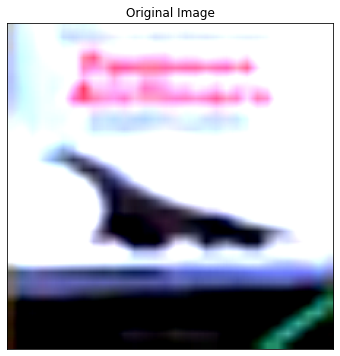

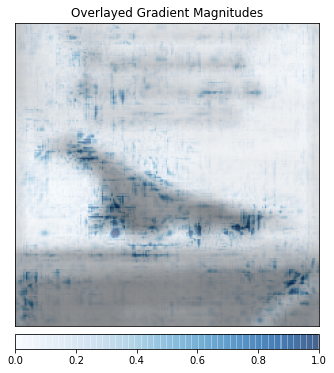

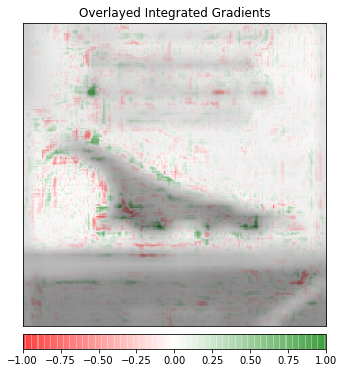

In [21]:
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")


Useful Resources: <br>
https://www.youtube.com/watch?v=0QLrRyLndFI <br>
https://www.youtube.com/watch?v=sub-0ZE5Xoo <br>